# EDA for Wildfire detection - Part 4 (Prediction Planning)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from IPython.display import display
from scipy.stats import ttest_ind, norm, f
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm

In [2]:
from myLib import check_missing, check_column_sources, check_missing_row_overlap, check_missing_and_plot, plot_missing_spatial

## 1. Prepare fire event dataframe (Cleaned)

Read the following csv files:
- fire_events_df_2023: integrated csv file includes ignition and detection day
- df_cfsds_pts_2023_clean: cleaned csv file from CFSDS 2023

In [13]:
path = "../output/fire_events_df_2023.csv"
fire_events_df_2023 = pd.read_csv(path)
print(f"Load dataframe from {path}, \nShape: {fire_events_df_2023.shape}")
display(fire_events_df_2023.head())

Load dataframe from ../output/fire_events_df_2023.csv, 
Shape: (408, 58)


,ID,year,fire_number,ignition_date,lon,lat,modis_acq_date,detection_delay_days,DOB,fireday,...,nonfuel5k,nonfuel10k,dem,slope,twi,aspect,cumuarea,pctgrowth,prevgrow,sprdistm
0,2023_1,2023,1,2023-07-13,-120.132411,65.169616,2023-07-14,1,194,1,...,0.388660,0.434968,160.333328,2.923349,8.141331,0.184916,55.89,0.0,0.0,843.571918
1,2023_2,2023,2,2023-07-21,-115.510326,66.083561,2023-07-22,1,202,1,...,0.422344,0.414876,423.444458,7.380778,4.917335,67.092438,75.33,0.0,0.0,979.352515
2,2023_3,2023,3,2023-07-25,-116.750961,65.775854,2023-07-26,1,206,1,...,0.315463,0.292883,386.222229,15.139147,5.079659,180.293304,34.02,0.0,0.0,658.145951
3,2023_10,2023,10,2023-07-01,-131.612507,65.975299,2023-07-03,2,182,1,...,0.317330,0.253425,234.000000,0.979205,5.813332,161.413071,2.43,0.0,0.0,175.896904
4,2023_11,2023,11,2023-07-29,-127.447260,67.987183,2023-08-02,4,210,1,...,0.013489,0.086612,209.888885,2.824383,6.089895,29.511507,5.67,0.0,0.0,268.686959


In [6]:
# Save cleaned DataFrame to CSV
path = "../output/df_cfsds_pts_2023_clean.csv"

df_cfsds_pts_2023_clean = pd.read_csv(path)
print(f"Load dataframe from {path}, \nShape: {df_cfsds_pts_2023_clean.shape}")
display(df_cfsds_pts_2023_clean.head())

Load dataframe from ../output/df_cfsds_pts_2023_clean.csv, 
Shape: (9805201, 54)


,ID,DOB,year,fireday,firearea,ecozone,fwi,isi,ffmc,dmc,...,dem,slope,twi,aspect,cumuarea,pctgrowth,prevgrow,sprdistm,lon,lat
0,2023_1,199,2023,6,34.83,4.0,12.689084,3.413085,87.002037,57.022739,...,155.888885,0.635593,8.542518,19.364168,584.01,6.342183,122.31,82.564522,-120.243573,65.162707
1,2023_1,200,2023,7,8.91,4.0,12.562475,3.274614,87.347870,59.742805,...,159.111115,1.295400,8.378138,65.199997,592.92,1.525659,34.83,20.722663,-120.242807,65.161939
2,2023_1,199,2023,6,34.83,4.0,12.689084,3.413085,87.002037,57.022739,...,157.555557,1.379041,8.435522,3.923952,584.01,6.342183,122.31,82.564522,-120.240982,65.162261
3,2023_1,198,2023,5,122.31,4.0,17.889744,5.501473,87.002037,54.540680,...,158.777771,0.873803,8.435522,3.923952,549.18,28.652751,182.25,312.984996,-120.239156,65.162582
4,2023_1,198,2023,5,122.31,4.0,17.889744,5.501473,87.002037,54.540680,...,156.888885,1.153590,8.310710,333.121857,549.18,28.652751,182.25,312.984996,-120.237330,65.162904


In [3]:
fire_events_df_2023['delay_group'] = pd.cut(
    fire_events_df_2023['detection_delay_days'],
    bins=[0, 1, 3, 7, 30],
    labels=['<1d', '1-3d', '3-7d', '>7d']
)

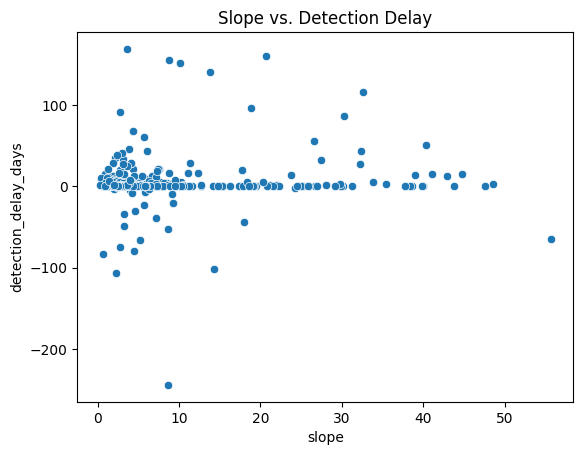

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=fire_events_df_2023, x='slope', y='detection_delay_days')
plt.title('Slope vs. Detection Delay')
plt.show()

In [8]:
display(fire_events_df_2023.head())

,ID,year,fire_number,ignition_date,lon,lat,modis_acq_date,detection_delay_days,DOB,fireday,...,dem,slope,twi,aspect,cumuarea,pctgrowth,prevgrow,sprdistm,delay_group,max_fireday
0,2023_1,2023,1,2023-07-13,-120.132411,65.169616,2023-07-14,1,194,1,...,160.333328,2.923349,8.141331,0.184916,55.89,0.0,0.0,843.571918,<1d,27
1,2023_2,2023,2,2023-07-21,-115.510326,66.083561,2023-07-22,1,202,1,...,423.444458,7.380778,4.917335,67.092438,75.33,0.0,0.0,979.352515,<1d,14
2,2023_3,2023,3,2023-07-25,-116.750961,65.775854,2023-07-26,1,206,1,...,386.222229,15.139147,5.079659,180.293304,34.02,0.0,0.0,658.145951,<1d,19
3,2023_10,2023,10,2023-07-01,-131.612507,65.975299,2023-07-03,2,182,1,...,234.000000,0.979205,5.813332,161.413071,2.43,0.0,0.0,175.896904,1-3d,27
4,2023_11,2023,11,2023-07-29,-127.447260,67.987183,2023-08-02,4,210,1,...,209.888885,2.824383,6.089895,29.511507,5.67,0.0,0.0,268.686959,3-7d,5


In [14]:
# Step 1: Calculate the maximum fireday for each unique fire ID
id_to_max_fireday = df_cfsds_pts_2023_clean.groupby("ID")["fireday"].max()

# Step 2: Map the maximum fireday back to the fire_events_df_2023 DataFrame
fire_events_df_2023["max_fireday"] = fire_events_df_2023["ID"].map(id_to_max_fireday)

# Reorder columns
cols = fire_events_df_2023.columns.tolist()
prefix_cols = ['ID', 'year', 'fire_number', 'ignition_date', 'lon', 'lat', 'modis_acq_date', 'detection_delay_days', 'max_fireday']
new_order = prefix_cols + [col for col in cols if col not in prefix_cols]
fire_events_df_2023 = fire_events_df_2023[new_order]
display(fire_events_df_2023[["ID", "detection_delay_days", "max_fireday"]].head())

,ID,detection_delay_days,max_fireday
0,2023_1,1,27
1,2023_2,1,14
2,2023_3,1,19
3,2023_10,2,27
4,2023_11,4,5


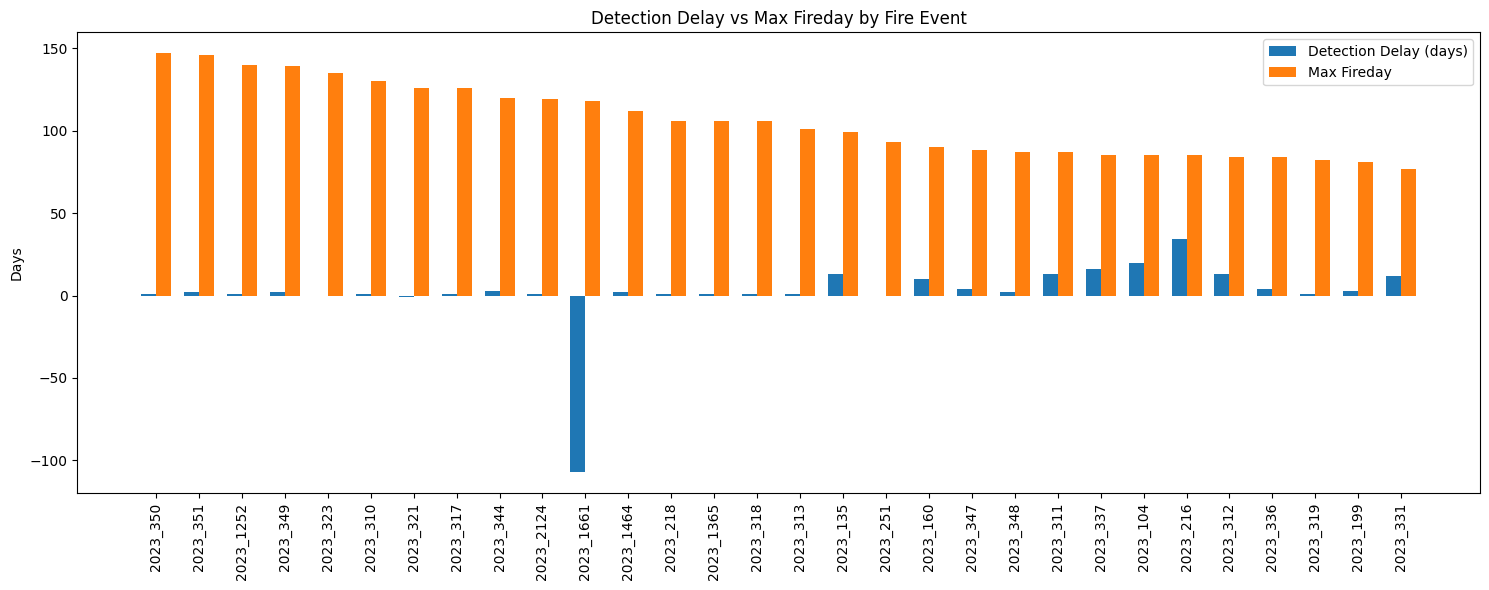

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Select columns to plot
plot_df = fire_events_df_2023[["ID", "detection_delay_days", "max_fireday"]].copy()

# Limit to a smaller sample if too many bars (optional)
plot_df = plot_df.sort_values("max_fireday", ascending=False).head(30)

# Set position for each bar
x = np.arange(len(plot_df["ID"]))  # the label locations
width = 0.35  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

bars1 = ax.bar(x - width/2, plot_df["detection_delay_days"], width, label="Detection Delay (days)")
bars2 = ax.bar(x + width/2, plot_df["max_fireday"], width, label="Max Fireday")

# Add labels and title
ax.set_ylabel("Days")
ax.set_title("Detection Delay vs Max Fireday by Fire Event")
ax.set_xticks(x)
ax.set_xticklabels(plot_df["ID"], rotation=90)
ax.legend()

# Layout adjustment
plt.tight_layout()
plt.show()

In [16]:
# Find rows with negative detection delay
neg_delay_df = fire_events_df_2023[fire_events_df_2023['detection_delay_days'] < 0]

# Check related dates
display(neg_delay_df[['ID', 'ignition_date', 'modis_acq_date', 'detection_delay_days']])

,ID,ignition_date,modis_acq_date,detection_delay_days
38,2023_111,2023-07-05,2023-07-02,-3
45,2023_122,2023-07-01,2023-06-26,-5
58,2023_136,2023-08-11,2023-05-29,-74
176,2023_268,2023-08-09,2023-08-07,-2
179,2023_271,2023-08-27,2023-07-09,-49
203,2023_321,2023-05-20,2023-05-19,-1
236,2023_1001,2023-07-21,2023-07-01,-20
238,2023_1005,2023-07-22,2023-05-04,-79
239,2023_1010,2023-08-06,2023-06-01,-66
240,2023_1012,2023-09-22,2023-07-01,-83
